In [ ]:
from minisom import MiniSom

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Iris data
----

Training...

...ready!


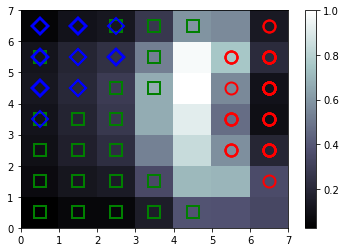

In [8]:
data = np.genfromtxt('iris.csv', delimiter=',', usecols=(0, 1, 2, 3))
# data normalization
data = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, data)

# Initialization and training
som = MiniSom(7, 7, 4, sigma=1.0, learning_rate=0.5)
som.random_weights_init(data)
print("Training...")
som.train_random(data, 100)  # random training
print("\n...ready!")

# Plotting the response for each pattern in the iris dataset
plt.bone()
plt.pcolor(som.distance_map().T)  # plotting the distance map as background
plt.colorbar()

target = np.genfromtxt('iris.csv', delimiter=',', usecols=(4), dtype=str)
t = np.zeros(len(target), dtype=int)
t[target == 'setosa'] = 0
t[target == 'versicolor'] = 1
t[target == 'virginica'] = 2

# use different colors and markers for each label
markers = ['o', 's', 'D']
colors = ['r', 'g', 'b']
for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[t[cnt]], markerfacecolor='None',
             markeredgecolor=colors[t[cnt]], markersize=12, markeredgewidth=2)
plt.axis([0, 7, 0, 7])
plt.show()

Color quantization
----

training...
quantization...
building new image...
done.


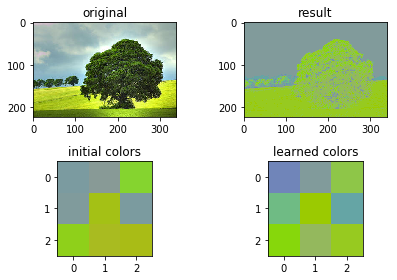

In [16]:
# read the image
img = plt.imread('tree.jpg')

# reshaping the pixels matrix
pixels = np.reshape(img, (img.shape[0]*img.shape[1], 3))

# SOM initialization and training
print('training...')
som = MiniSom(3, 3, 3, sigma=0.1, learning_rate=0.2)  # 3x3 = 9 final colors
som.random_weights_init(pixels)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train_random(pixels, 100)

print('quantization...')
qnt = som.quantization(pixels)  # quantize each pixels of the image
print('building new image...')
clustered = np.zeros(img.shape)
for i, q in enumerate(qnt):  # place the quantized values into a new image
    clustered[np.unravel_index(i, dims=(img.shape[0], img.shape[1]))] = q
print('done.')

# show the result
plt.figure(1)
plt.subplot(221)
plt.title('original')
plt.imshow(img)
plt.subplot(222)
plt.title('result')
plt.imshow(clustered)

plt.subplot(223)
plt.title('initial colors')
plt.imshow(starting_weights, interpolation='none')
plt.subplot(224)
plt.title('learned colors')
plt.imshow(som.get_weights(), interpolation='none')

plt.tight_layout()
plt.show()

Handwritten digits
----

Training...

...ready!


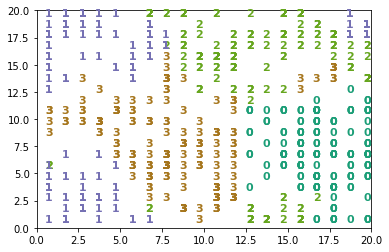

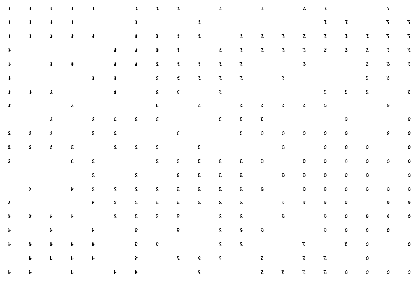

In [20]:
from sklearn import datasets

# load the digits dataset from scikit-learn
# 901 samples,  about 180 samples per class
# the digits represented 0, 1, 2, 3, 4

digits = datasets.load_digits(n_class=4)
data = digits.data  # matrix where each row is a vector that represent a digit.
num = digits.target  # num[i] is the digit represented by data[i]

som = MiniSom(20, 20, 64, sigma=.8, learning_rate=0.5)
print("Training...")
som.train_random(data, 1500)  # random training
print("\n...ready!")

wmap = {}
plt.figure(1)
im = 0
for x, t in zip(data, num):  # scatterplot
    w = som.winner(x)
    wmap[w] = im
    plt. text(w[0]+.5,  w[1]+.5,  str(t),
              color=plt.cm.Dark2(t / 4.), fontdict={'weight': 'bold',  'size': 11})
    im = im + 1
plt.axis([0, som.get_weights().shape[0], 0,  som.get_weights().shape[1]])

plt.figure(2, facecolor='white')
cnt = 0
for j in reversed(range(20)):  # images mosaic
    for i in range(20):
        plt.subplot(20, 20, cnt+1, frameon=False,  xticks=[],  yticks=[])
        if (i, j) in wmap:
            plt.imshow(digits.images[wmap[(i, j)]],
                       cmap='Greys', interpolation='nearest')
        else:
            plt.imshow(np.zeros((8, 8)),  cmap='Greys')
        cnt = cnt + 1

plt.tight_layout()
plt.show()  # show the figure